In [1]:
import numpy as np
from basicpy import BaSiC
from scipy.ndimage import zoom
import zarr
from numcodecs import GZip 

from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
def transform(images, f, d=None):
    if d is not None:
        images_transformed = (np.clip(images-d[np.newaxis],0,None))/f[np.newaxis]
    else:
        images_transformed = images/f[np.newaxis]
        
    return images_transformed

In [3]:
path = "/u/scratch/f/f7xiesnm/sparse06/dataset.n5"
zarr_data = zarr.open(store=zarr.N5Store(path), mode='r')

In [4]:
print(zarr_data[f'/setup0/timepoint0/s0'].shape)
print(zarr_data[f'/setup0/timepoint0/s1'].shape)
print(zarr_data[f'/setup0/timepoint0/s2'].shape)
print(zarr_data[f'/setup0/timepoint0/s3'].shape)
print(zarr_data[f'/setup0/timepoint0/s4'].shape)

(2837, 1920, 1920)
(2837, 960, 960)
(1418, 480, 480)
(709, 240, 240)
(354, 120, 120)


In [5]:
base_idx = np.array([
    1,2,3,
    6,7,8,
    11,12,13,
    16,17,18,
    ])

# c0 - 0
# c2 - +20*2
# c4 - +20*4

idxs = base_idx + 20*4


images_raw = np.vstack([zarr_data[f'/setup{i}/timepoint0/s4'][...] for i in idxs])
images_raw.shape

(4248, 120, 120)

In [6]:
pctls = [1, 5, 10, 
         20, 40, 50, 
         80, 90, 95, 
         99, 99.2, 99.4, 
         99.6, 99.8, 99.9]
vects = []
for pctl in pctls:
    vec = np.percentile(images_raw, pctl, axis=0)
    vects.append(vec)

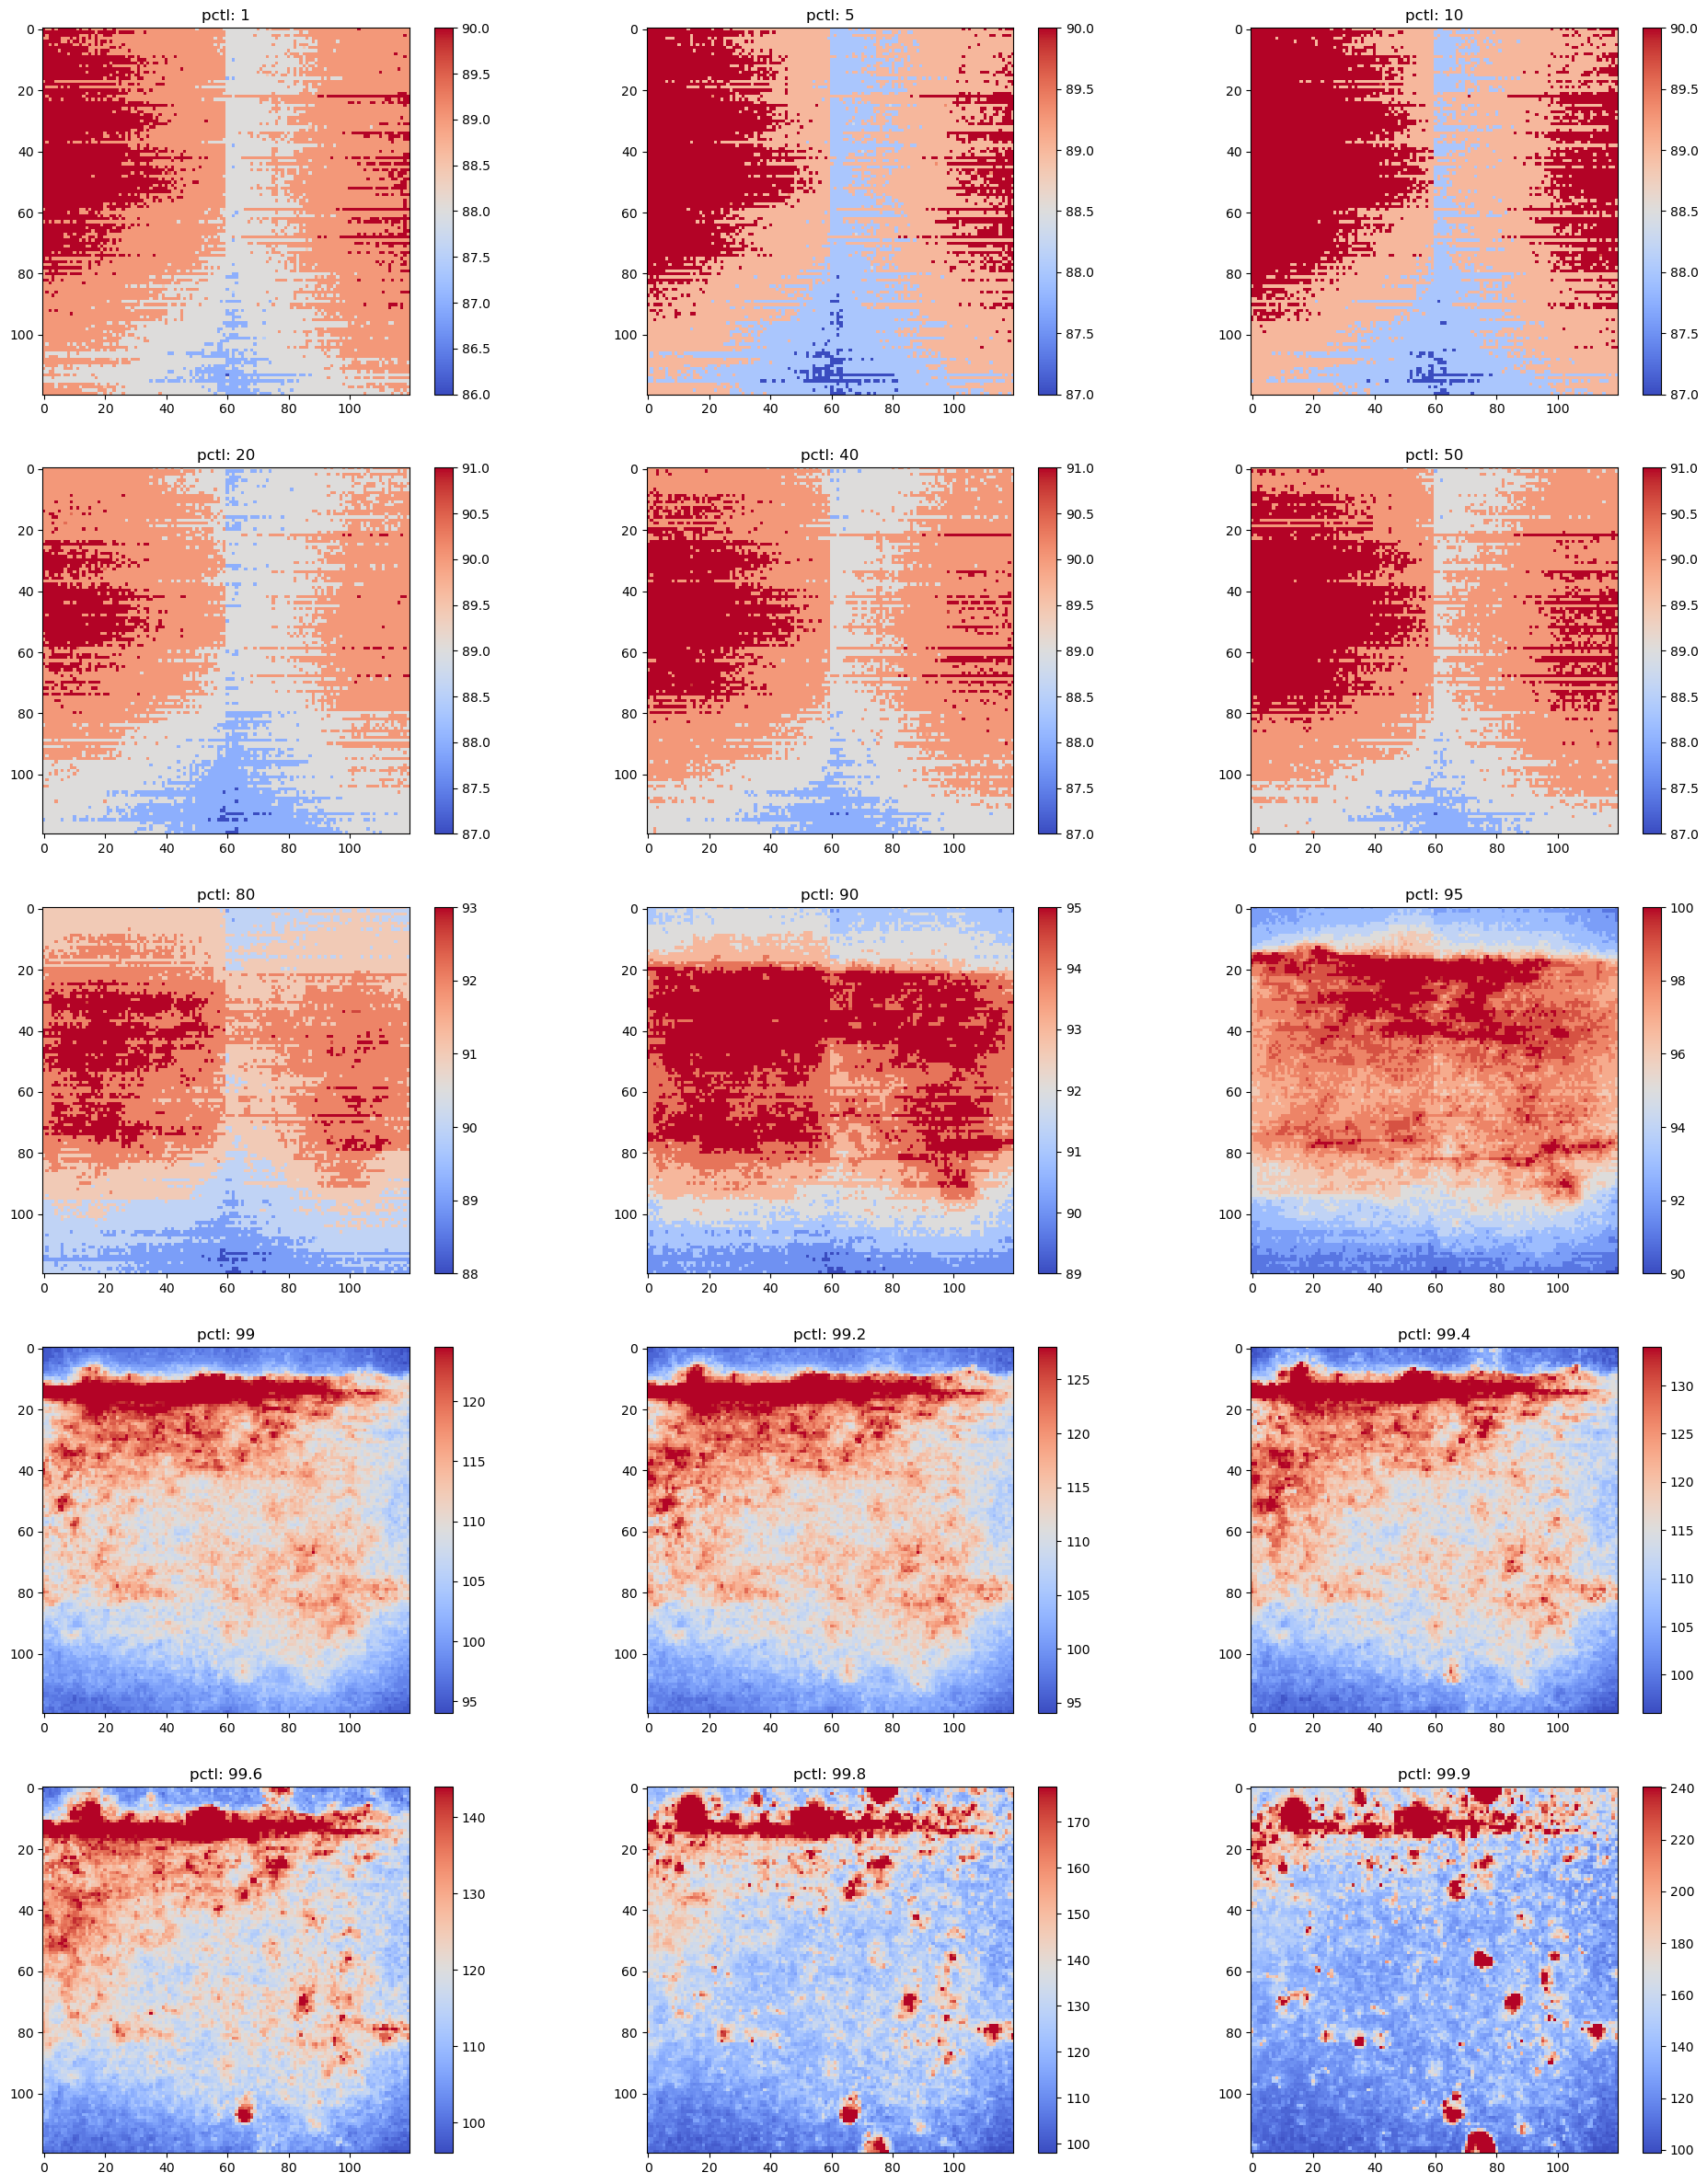

In [7]:
fig, axs = plt.subplots(5,3, figsize=(3*8,5*6))
for ax, pctl, vec in zip(axs.flat, pctls, vects): 
    vmax = np.percentile(vec, 95)
    vmin = np.percentile(vec,  5)
    g = ax.imshow(vec, cmap='coolwarm', vmax=vmax)
    ax.set_title(f'pctl: {pctl}')
    fig.colorbar(g)

plt.show()

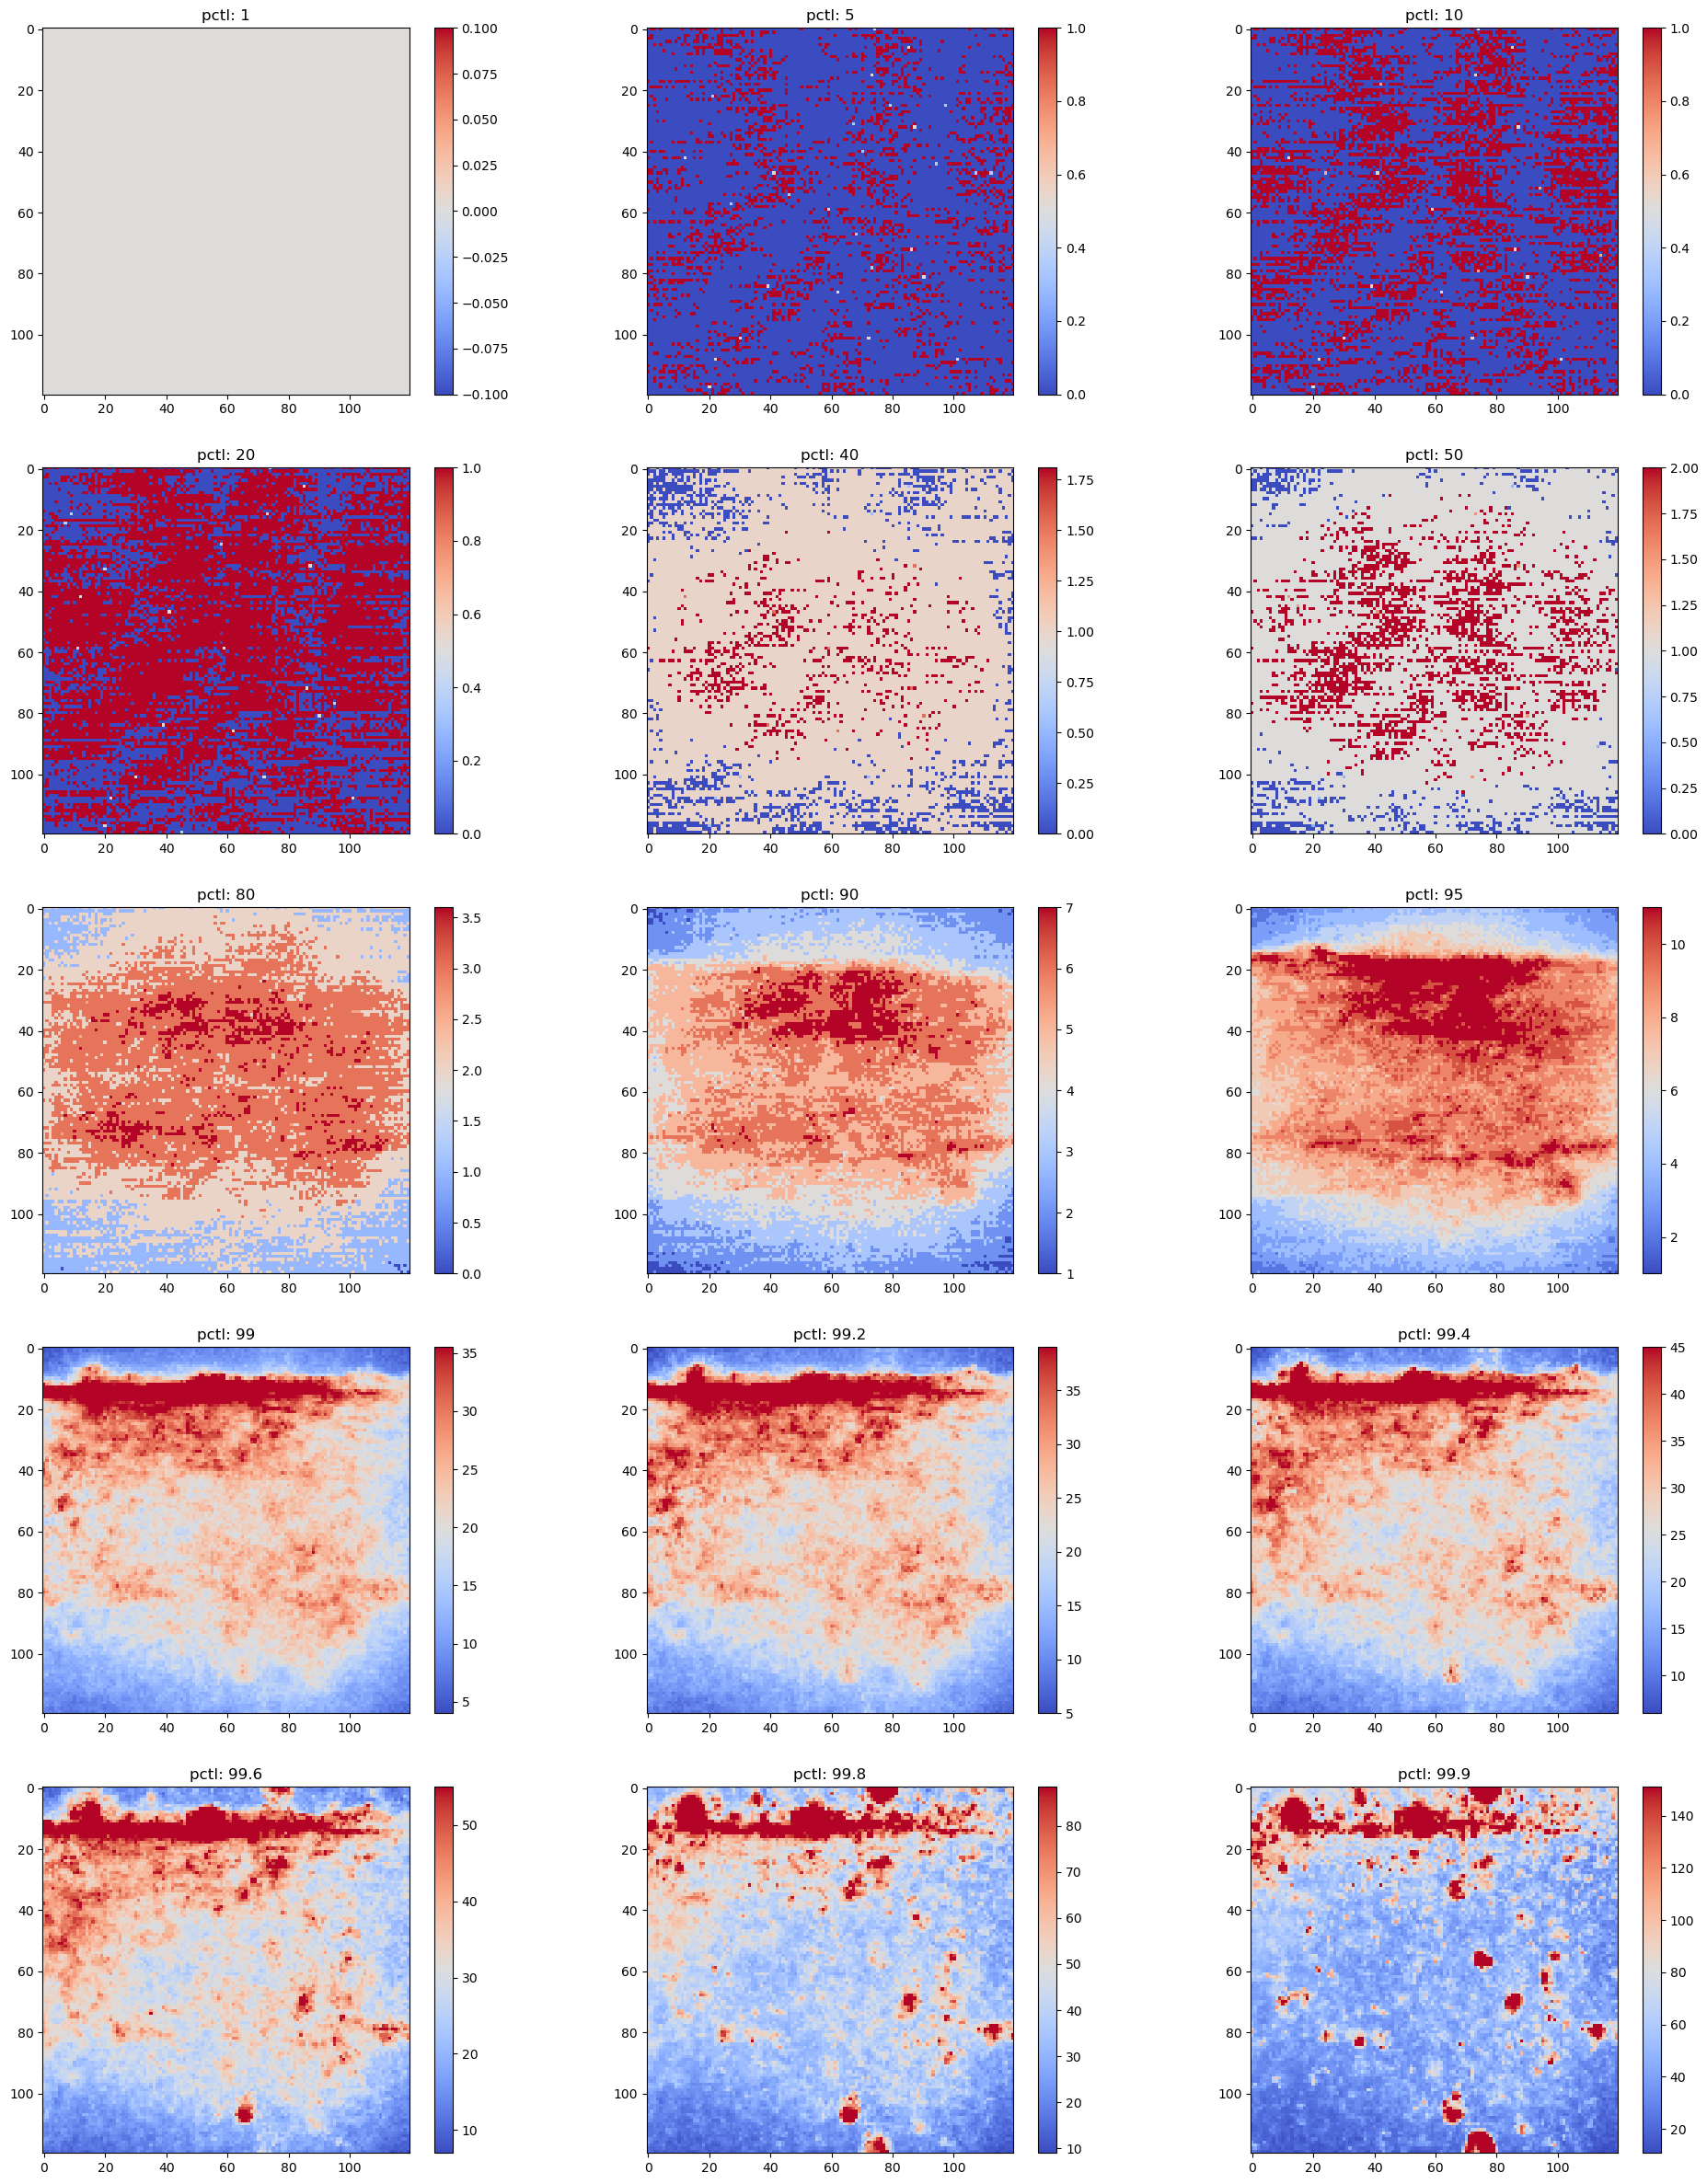

In [8]:
fig, axs = plt.subplots(5,3, figsize=(3*8,5*6))
for ax, pctl, vec in zip(axs.flat, pctls, vects): 
    vec = vec - vects[0]
    vmax = np.percentile(vec, 95)
    vmin = np.percentile(vec,  5)
    g = ax.imshow(vec, cmap='coolwarm', vmax=vmax)
    ax.set_title(f'pctl: {pctl}')
    fig.colorbar(g)
plt.show()

In [9]:
# correct it

In [10]:
# images = zarr_data[f'/setup13/timepoint0/s4'][...]
images = images_raw.copy()
dx = np.percentile(images,1, axis=0)
images = np.clip(images.astype(np.float16) - dx, 0, 1000).astype(np.uint16)

In [11]:
from skimage import restoration

ff0 = np.percentile(images, 99, axis=0)
bg = restoration.rolling_ball(ff0, radius=20)
ff = bg / np.mean(bg)

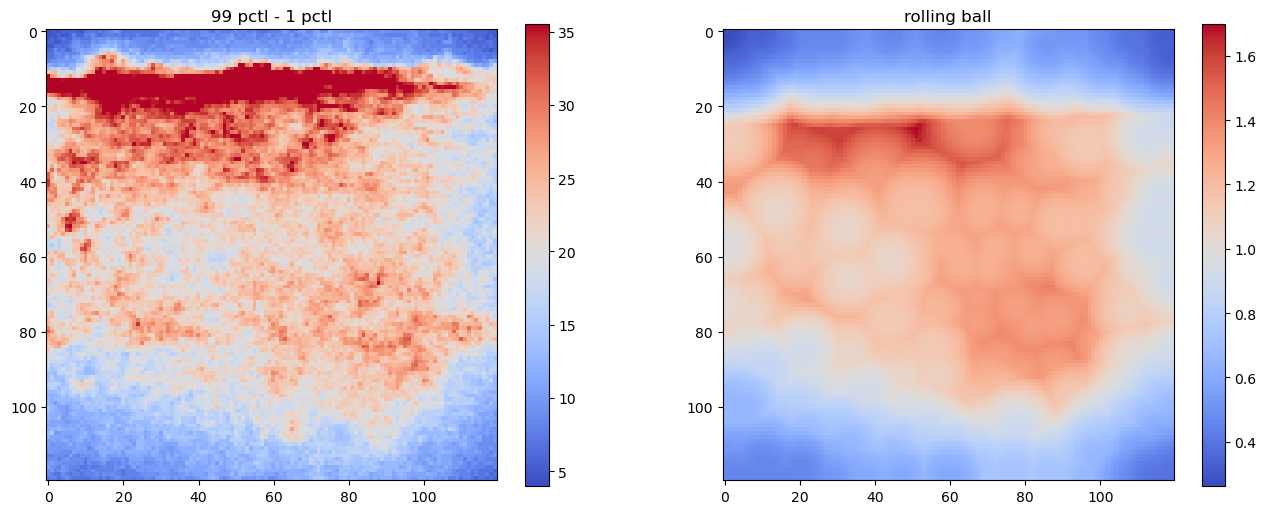

In [12]:
fig, axs = plt.subplots(1,2,figsize=(8*2, 6))

ax = axs[0]
vmax = np.percentile(ff0, 95)
g = ax.imshow(ff0, vmax=vmax, cmap='coolwarm') #, vmin=0, vmax=2)
ax.set_title('99 pctl - 1 pctl')
plt.colorbar(g)

ax = axs[1]
g = ax.imshow(ff, cmap='coolwarm',) # vmid=1) # vmin=0, vmax=2)
ax.set_title('rolling ball')
fig.colorbar(g)

plt.show()

100
7.956837892532349


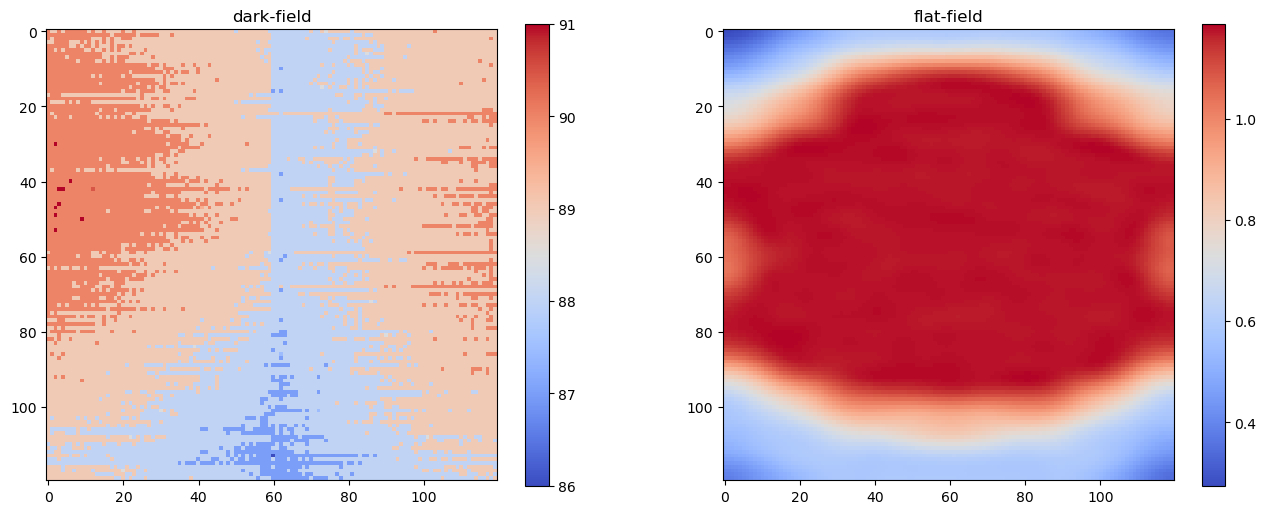

200
13.674103498458862


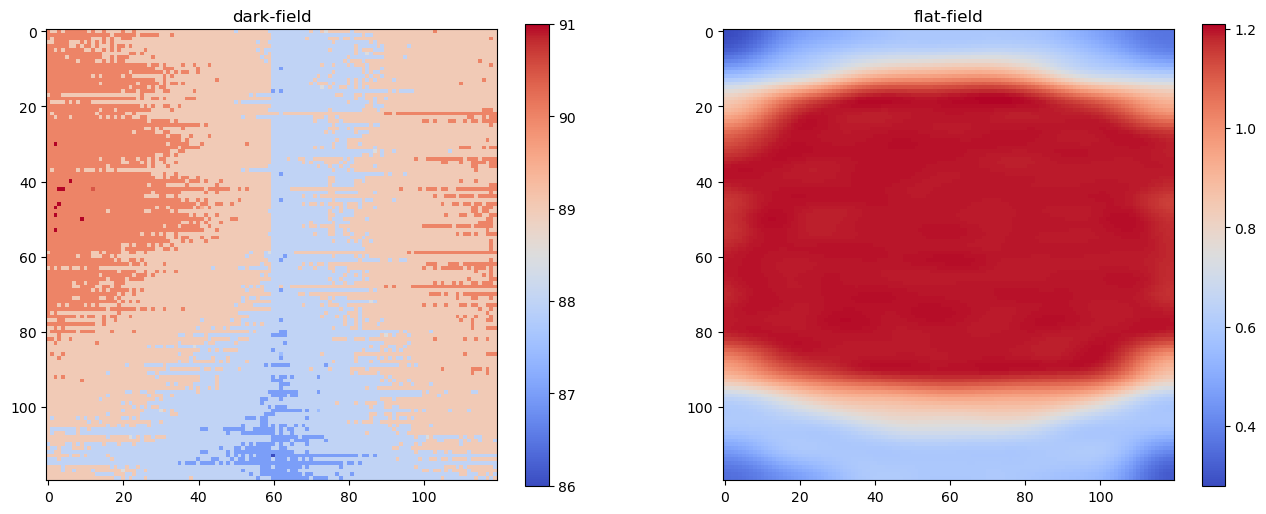

400
30.19086980819702


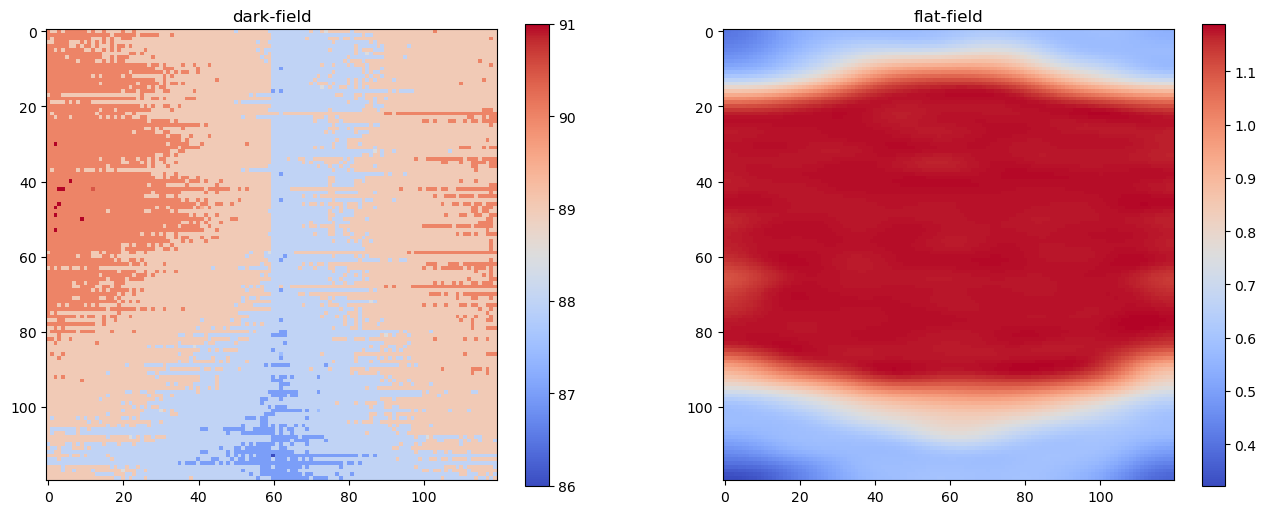

800
58.75448155403137


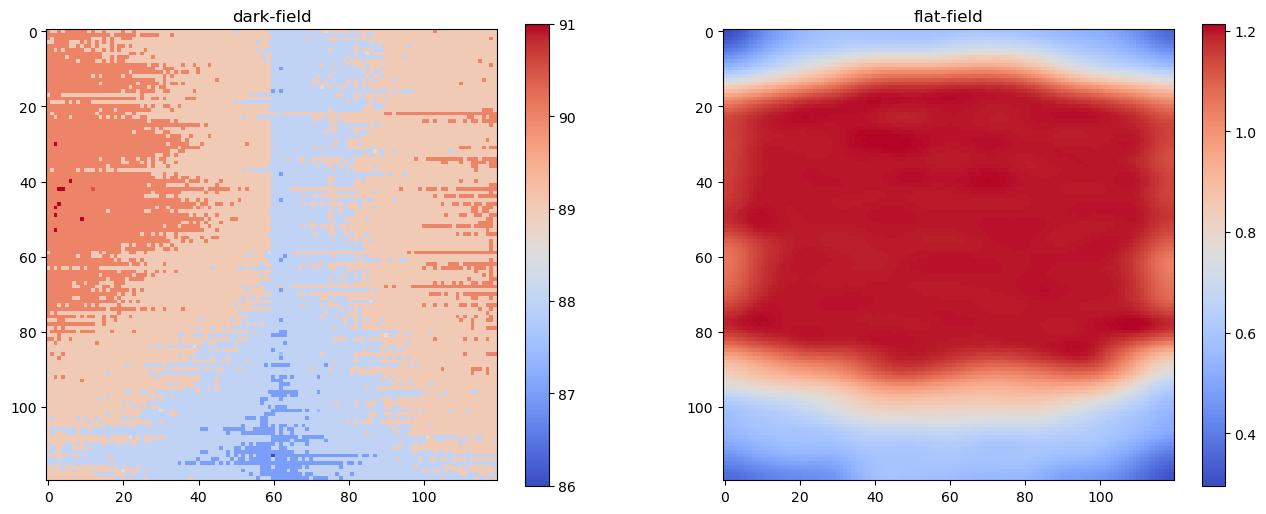

1600
188.29567289352417


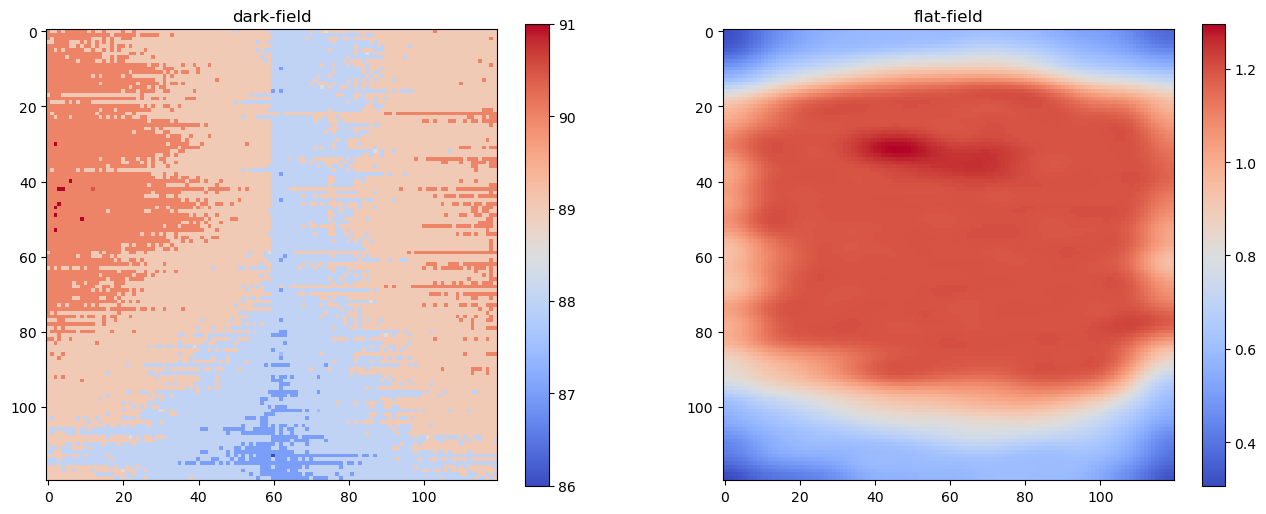

4248
904.7654976844788


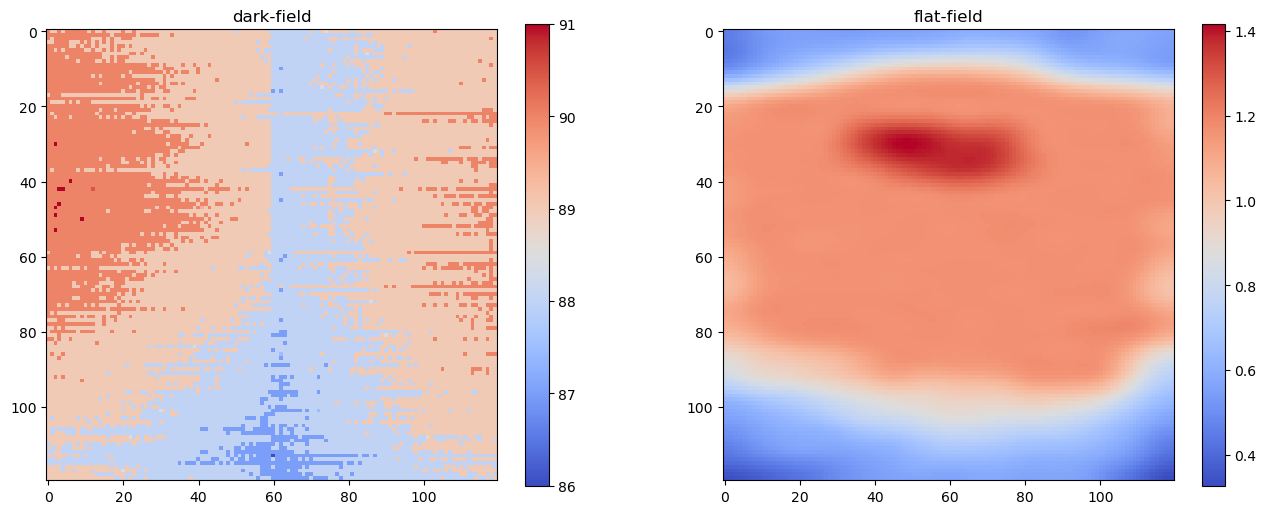

CPU times: user 52min 33s, sys: 3min 32s, total: 56min 5s
Wall time: 20min 5s


In [13]:
%%time
import time

np.random.seed(0)

for n in [100, 200, 400, 800, 1600, len(images)]:
    ti = time.time()
    print(n)
    
    idx = np.random.choice(len(images), n, replace=False)
    basic = BaSiC(get_darkfield=False, smoothness_flatfield=1, working_size=None, sort_intensity=True)
    basic.fit(images[idx])
    
    ff = basic.flatfield
    
    print(time.time()-ti)
    
    fig, axs = plt.subplots(1,2,figsize=(8*2, 6))
    ax = axs[0]
    g = ax.imshow(dx, cmap='coolwarm') #, vmin=0, vmax=2)
    ax.set_title('dark-field')
    plt.colorbar(g)
    ax = axs[1]
    g = ax.imshow(ff, cmap='coolwarm',) # vmid=1) # vmin=0, vmax=2)
    ax.set_title('flat-field')
    fig.colorbar(g)
    plt.show()
    

In [14]:
import tifffile
outdir = '/u/home/f/f7xiesnm/project-zipursky/easifish/results/sparse06_r1c0_flatfield'
!mkdir -p $outdir

tifffile.imwrite(outdir+'/darkfield_bs_c4.tiff', dx)
tifffile.imwrite(outdir+'/flatfield_bs_c4.tiff', ff)

In [15]:
!ls $outdir
dx = tifffile.imread(outdir+'/darkfield_bs_c4.tiff')
ff = tifffile.imread(outdir+'/flatfield_bs_c4.tiff')
dx, ff

darkfield_bs_c2.tiff  darkfield.tiff	    flatfield_rb.tiff
darkfield_bs_c4.tiff  flatfield_bs_c2.tiff  flatfield.tiff
darkfield_bs.tiff     flatfield_bs_c4.tiff
darkfield_rb.tiff     flatfield_bs.tiff


(array([[90., 89., 89., ..., 89., 89., 89.],
        [90., 90., 90., ..., 89., 89., 89.],
        [90., 89., 90., ..., 89., 90., 89.],
        ...,
        [89., 89., 89., ..., 89., 89., 89.],
        [89., 89., 89., ..., 88., 89., 88.],
        [89., 89., 89., ..., 89., 88., 89.]]),
 array([[0.45363408, 0.45587885, 0.46019503, ..., 0.5635455 , 0.5625663 ,
         0.56207985],
        [0.45384645, 0.45603177, 0.46023104, ..., 0.5600539 , 0.5588893 ,
         0.5583083 ],
        [0.45252025, 0.45468202, 0.45883426, ..., 0.55577147, 0.5543972 ,
         0.5537089 ],
        ...,
        [0.3637168 , 0.36476603, 0.36678013, ..., 0.3569494 , 0.35237056,
         0.35003656],
        [0.3476208 , 0.3486368 , 0.35059434, ..., 0.34222412, 0.33756223,
         0.3351844 ],
        [0.33888182, 0.3398722 , 0.34178454, ..., 0.33339885, 0.32864627,
         0.3262213 ]], dtype=float32))